https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

# Convolutional model input

In [14]:

import keras
from keras import applications
from keras import backend as K
import tensorflow as tf

In [109]:

# build the VGG16 network
model = applications.VGG16(include_top=True,
                           weights='imagenet')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [110]:
weights=model.get_layer('predictions').get_weights()
kernel=weights[0]
bias=weights[1]
print(kernel.shape)
print(bias.shape)

(4096, 1000)
(1000,)


In [135]:
layer_name = 'fc2'

intermediate_layer_model = keras.models.Model(inputs=model.get_input_at(0),
                                 outputs=model.get_layer(layer_name).output)
inp=keras.layers.Input(shape =(224,224,3))
x=intermediate_layer_model(inp)
model1=keras.layers.Dense(1000, activation=None, use_bias=True, kernel_initializer=tf.constant_initializer(kernel), bias_initializer=tf.constant_initializer(bias))(x)  

In [80]:
model.get_input_shape_at(0)

(None, 224, 224, 3)

In [136]:
output_index=125
reg=0.01

In [137]:
# compute the gradient of the input picture wrt this loss
input_img=keras.layers.Input(shape =(224,224,3))
x=intermediate_layer_model(input_img)
x=keras.layers.Dense(1000, activation=None, use_bias=True, kernel_initializer=tf.constant_initializer(kernel), bias_initializer=tf.constant_initializer(bias))(x)  
model1=keras.models.Model(inputs=input_img,outputs=x)
#input_img=tf.Variable(np.random.random((1, 3, 224, 224)) * 20 + 128)
loss = K.mean(model1(input_img)[:, output_index])- reg*K.mean(K.square(input_img))
grads = K.gradients(loss, input_img)[0]
# normalization trick: we normalize the gradient
#grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

-201.92


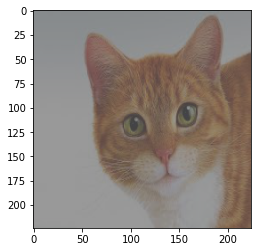

7.68516


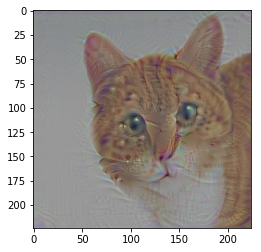

11.6964


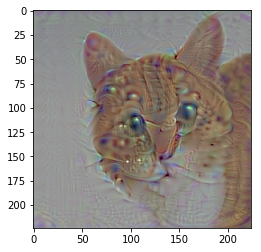

13.4323


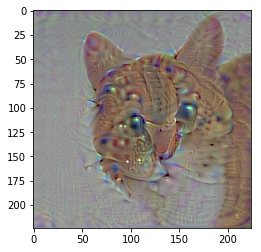

14.5147


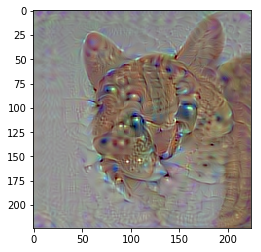

15.2813


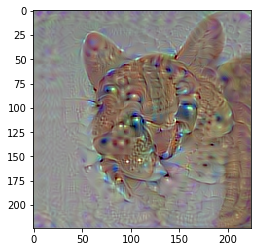

15.8478


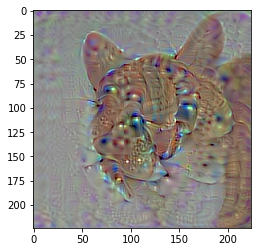

16.302


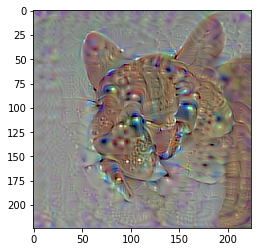

16.6731


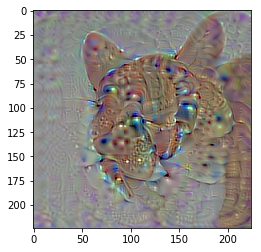

17.0027


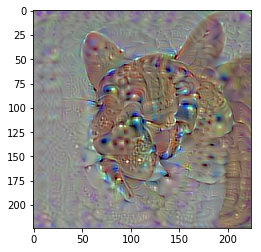

In [138]:
import numpy as np
import scipy 
water=scipy.misc.imread(r"C:\Users\USER\Desktop\Cat1.jpg")
water=scipy.misc.imresize(water,(224,224,3))
water=water/255.0
water=np.expand_dims(water,axis=0)
# we start from a gray image with some noise
input_img_data = np.random.random((1, 224,224,3)) * 20 + 128.
input_img_data =water*20 +128                  
# run gradient ascent for 20 steps
for i in range(200):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value *1
    if(i%20==0):
        img = input_img_data[0]
        img = deprocess_image(img)
        print(loss_value)
        plt.imshow(img)
        plt.show()

(224, 224, 3)


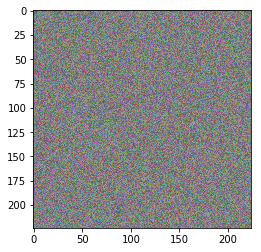

In [51]:
import matplotlib.pyplot as plt
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
print(img.shape)
plt.imshow(img)
plt.show()
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

# Saliency maps

https://www.kaggle.com/ernie55ernie/mnist-with-keras-visualization-and-saliency-map

In [15]:
# Saliency map
# https://github.com/experiencor/deep-viz-keras/blob/master/saliency.py
from keras.models import Model
from keras.initializers import Ones, Zeros

class SaliencyMask(object):
    def __init__(self, model, output_index=0):
        pass

    def get_mask(self, input_image):
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image, dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

class GradientSaliency(SaliencyMask):

    def __init__(self, model, output_index = 0):
        # Define the function to compute the gradient
        input_tensors = [model.input]
        gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
        self.compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

    def get_mask(self, input_image):
        # Execute the function to compute the gradient
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value])[0][0]

        return gradients

In [16]:
mnist=keras.datasets.mnist

In [17]:
(x_train,y_train), (x_test,y_test)=mnist.load_data()

In [18]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28,1).astype('float32')
x_train=x_train/255.0
x_test=x_test/255.0
#y_train=keras.utils.to_categorical(y_train)
#y_test=keras.utils.to_categorical(y_test)

In [19]:
model=keras.models.load_model(r"C:\Users\USER\Desktop\inverting convolutional layers\Max pooling\model.pkl")

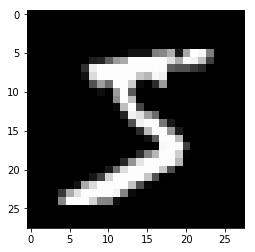

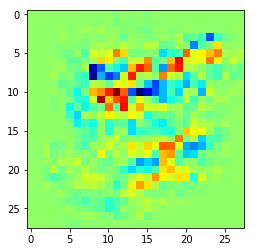

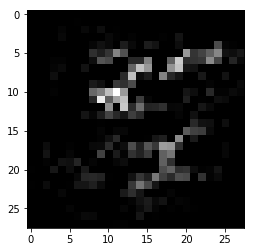

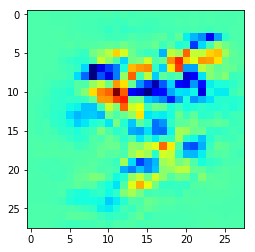

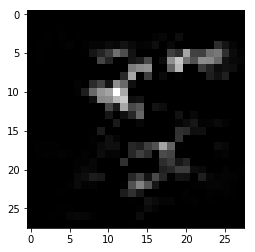

In [21]:
import matplotlib.pyplot as plt
import numpy as np

#fig, ax = plt.subplots(10, 5, figsize = (12, 16))
#fig.suptitle('vanilla gradient')

img = x_train[0]

vanilla = GradientSaliency(model, 5)
mask = vanilla.get_mask(img)
filter_mask = (mask > 0.0).reshape((28, 28))
smooth_mask = vanilla.get_smoothed_mask(img)
filter_smoothed_mask = (smooth_mask > 0.0).reshape((28, 28))

plt.imshow(img.reshape((28, 28)), cmap = 'gray')
plt.show()
plt.imshow(mask.reshape((28, 28)), cmap = 'jet')
plt.show()
#fig.colorbar(cax, ax = ax[i, 1])
plt.imshow(mask.reshape((28, 28)) * filter_mask, cmap = 'gray')
plt.show()
plt.imshow(smooth_mask.reshape((28, 28)), cmap = 'jet')
plt.show()
#fig.colorbar(cax, ax = ax[i, 3])
plt.imshow(smooth_mask.reshape((28, 28)) * filter_smoothed_mask, cmap = 'gray')

plt.show()